# Import Required Libraries
This cell imports the necessary Python libraries for the analysis. It includes the custom `functions_main`   `functions_for_confidenceinterval`  library, `numpy` and `numpy.random` for numerical calculations, `matplotlib.pyplot` for data visualization.

In [1]:
from functions_main import * 
from functions_for_confidenceinterval import *  
import numpy as np
import cvxpy as cp
import numpy.random as rgt
from scipy.stats import norm
from joblib import Parallel, delayed 
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator 
from matplotlib.lines import Line2D 

# Model for Low-Dimensional Data 
We simulate low-dimensional data based on the model:


Y =  X β + b^{1/2}ε  


where the parameter vector β is defined as \{a, -a, a, -a, ...\}, with each value being either a or -a, parameter b controls the strength of the noise. 


## Inputs required

n/p: sample size/dimension
 
a: magnitude of β(coefficient); β=\{a, -a, a, -a, ...\}

b: scale of the noise ε; here, different a/b can reflect the different signal-to-noise ratios (SNRs)

alpha: significance level for CIs

Gaussian_covariate:  (1)True, X ~ N(0,1);   (2)False,  X ~ U(-sqrt{3},sqrt{3}) 

Gaussian_error: (1)True, ε ~ N(0,1);   (2)False,   ε ~ t_{2.25}  

## Useful functions 

In [2]:
####################### 1. DP estimation of standard deviation ########################
def St_DP(Y, epsilon):

    """
    (ε,0)-DP estimator of the standard deviation based on clipping and the Laplace mechanism.

    Parameters
    ----------
    Y :   response variables. 
    epsilon :  privacy parameter.
    """

    if epsilon <= 0:
        raise ValueError("epsilon must be positive.")

    n =  Y.size
    gamma = np.log(n)
    y =  np.clip(np.asarray(Y, dtype=float), -gamma, gamma)
    m1 = y.mean()
    m2 = np.mean(y**2)  
    Delta1 = 2*gamma / n
    Delta2 = (gamma**2) / n

    epsilon1 = epsilon2 = epsilon /2    # Split the privacy budget equally between the mean and second moment
    b1 = Delta1 / float(epsilon1)
    b2 = Delta2 / float(epsilon2)
    noise1 =  rgt.laplace(0.0, b1)
    noise2 =  rgt.laplace(0.0, b2) 
         
    m1_dp = m1 + noise1
    m2_dp = m2 + noise2
    var_dp = float(m2_dp - m1_dp**2)
    if var_dp > 0:
        st_dp = np.sqrt(var_dp)
    else:
        st_dp = 2.0
    return st_dp

#####################  2. huber & ridge initialization #####################  
def huber_ridge_priv(X, Y, tau, epsilon, delta): 

    '''
    Huber + ridge regression & output perturbation
    
    Parameters
    ---------
    X : n by p0 numpy array of covariates; each row is an observation vector. (no intercept)
    Y : response variables. 
    tau : (DP) robust parameter for huber regression.
    epsilon,delta : Privacy parameters.   
    '''

    n, p0 = X.shape
    gamma = np.sqrt(p0+1)/6 
    X_t = clipping_l2(X, gamma) 
 
    Z = np.hstack([np.ones((n, 1)), X_t])   # [1, X̃]
    beta = cp.Variable(p0 + 1) 

    resid = Y - Z  @ beta
    lam = 0.2 # Ridge regularization parameter
    obj = (1.0 / n) * cp.sum(cp.huber(resid, tau)) + 0.5 * lam * cp.sum_squares(  beta) 

    prob = cp.Problem(cp.Minimize(obj)) 
    prob.solve(solver="SCS", verbose=False, warm_start=True)

    b = np.asarray(beta.value).ravel() 
    B = np.sqrt(1 + gamma**2)
    noise_scale = 2*B*tau*((  ( 2 *np.log(1.25 /delta))**0.5 ))/(n*epsilon*lam)
    bDP = b + noise_scale * rgt.standard_normal(p0 + 1)
    return bDP   

###########  3. Compute the noise scale sigma_scale ################
def compute_sigma_scale(T, gamma, epsilon, delta):
    """
    Compute the noise scale sigma_scale for NoisyGD / DP gradient updates.

    Parameters
    ----------
    T :  Number of gradient descent iterations.
    gamma : L2 clipping bound.
    epsilon, delta : Privacy parameters. 
    """

    T = float(T)
    gamma = float(gamma)
    delta = float(delta)

    term1 = T * np.sqrt(2 * np.log(1.25 * T / delta))
    term2 = np.sqrt(5 * T * np.log(2 / delta) * np.log(2.5 * T / delta))
    base = 2 * gamma * (term1 if term1 < term2 else term2)
    eps_arr = np.asarray(epsilon, dtype=float)

    sigma_scale = base / eps_arr   
    if np.isscalar(epsilon):
        return float(sigma_scale)
    return sigma_scale

## 1. Estimation results

### 1.1. With and without initialization

#### 1.1.1. Main function

In [ ]:
def main_lowdim_init(n,p,a,b,Gaussian_covariate= True, Gaussian_error=True):
    # true beta
    rgt.seed(0) # set seed
    beta = a*np.ones(p)*(2*rgt.binomial(1, 0.5, size=p)-1) #   beta in {a,-a}  
    beta_norm = beta.dot(beta)**0.5 # the l2 norm of true beta 
      
    #privacy parameters 
    epsilon = .9 
    delta = 10/( n**1.1)
    epsilon_init = epsilon/6  # privacy budget for initialization: 1/6
    delta_init = delta/6 
    epsilon_est = 5*epsilon/6 # privacy budget for estmation: 5/6
    delta_est = 5*delta/6 
    
    repetitions = 300 # number of repetitions    
    rela_l2 = np.zeros([  repetitions])  # relative l2-error results of the non-private estimate 
    priv_rela_l2_init = np.zeros([  repetitions]) # relative l2-error results of the private estimate with initialization
    priv_rela_l2  = np.zeros([  repetitions]) # relative l2-error results of the private estimate without initialization
    for m in range(repetitions):
        rgt.seed(m+10) # set seed
        
        ############################################  
        ############# generate data ################  
        ############################################  
        # X 
        if Gaussian_covariate == True: X = rgt.normal(0, 1, size=(n,p-1)) 
        else: X = rgt.uniform(-np.sqrt(3),np.sqrt(3), size=(n,p-1))
        # error
        if Gaussian_error == True: err = rgt.normal(0,1, n)
        else: err = rgt.standard_t(2.25, n) 
        # Y
        Y = beta[0] + X.dot(beta[1:]) +    np.sqrt(b)*  err 
        
        ############################################### 
        #-------------  Private (proposed)  ----------- 
        ###############################################  
        
        #---- initialization ----
        epsilon_tau =  epsilon_init/4  # privacy budget for DP standard deviation estimation: 1/4
        epsilon_ridge =  3*epsilon_init/4 # privacy budget for DP huber+ridge estimation: 3/4
        tau_init =   St_DP(Y, epsilon = epsilon_tau)   
        beta_0DP =  huber_ridge_priv(X, Y, tau=tau_init, epsilon= epsilon_ridge, delta= delta_init) 

        #---- estimation ---- 
        gamma = 0.5*(p + np.log(n))**0.5 # truncation paramerter
        T = int(np.ceil(2*np.log(n))) # number of iterations
        sigma_scale = compute_sigma_scale(T, gamma, epsilon_est, delta_est)
        tau_priv = .04 * tau_init * (n * epsilon  /(p+np.log(n)))**0.5   
        lr_priv  =  0.2 # learning rate  
        model = Huber(X, Y,intercept=True)
        # with initialization
        out_priv_init = model.noisygd(tau=tau_priv, lr= lr_priv, beta0=beta_0DP, B=gamma , sigma_scale=sigma_scale,T=T)
        # without initialization
        sigma_scale_new = compute_sigma_scale(T, gamma, epsilon, delta)
        out_priv = model.noisygd(tau=tau_priv, lr= lr_priv, beta0=np.array([]), B=gamma , sigma_scale=sigma_scale_new,T=T)
        priv_rela_l2_init[m] = np.log(np.sum((out_priv_init['beta']  - beta )**2 )**0.5  / beta_norm)
        priv_rela_l2[m] = np.log(np.sum((out_priv['beta']  - beta )**2 )**0.5  / beta_norm)
              
        ############################################### 
        #----------------  Non-private  --------------- 
        ###############################################  
        model = Huber(X, Y,intercept=True)
        tau0 = np.sqrt(np.mean(Y**2)-(np.mean(Y))**2)
        tau_np = .2*tau0 * (n/(p+np.log(n)))**0.5  
        out  = model.gd(tau=tau_np,  lr= 0.5 , beta0=np.array([]), T=T) 
        rela_l2[m] = np.log(np.sum((out['beta']  - beta )**2 )**0.5  / beta_norm) 
           
           
    return np.array([priv_rela_l2_init,priv_rela_l2,rela_l2])

In [ ]:
# test
re_lowdim_init = main_lowdim_init(n=10000,p=5,a=2,b=0.5,Gaussian_covariate= True, Gaussian_error=True)
#print(np.mean(re_lowdim_init,axis=1))

#### 1.1.2. Main function adapted for parallel computing

In [3]:
def main_lowdim_init_parallel(m ):
    n_set = np.arange(2500, 10001, 500) 
    p_set = np.array([10]) 
    a_set = np.array([2]) 
    b_set = np.array([0.5]) 
    TF_set = np.array([True, False])  
    results = []
    for T1 in TF_set:
        for T2 in TF_set: 
            for p in p_set: 
                for a in a_set:
                    for b in b_set:
                        for n in n_set: 
                            # true beta
                            rgt.seed(0) # set seed
                            beta = a*np.ones(p)*(2*rgt.binomial(1, 0.5, size=p)-1) #   beta: {a,-a,a,...}  
                            beta_norm = beta.dot(beta)**0.5 # the l2 norm of true beta
                            
                            #privacy parameters 
                            epsilon = .9 
                            delta = 10/( n**1.1)
                            epsilon_init = 1*epsilon/6  # privacy budget for initialization: 1/6
                            delta_init = 1*delta/6 
                            epsilon_est = 5*epsilon/6 # privacy budget for estmation: 5/6
                            delta_est = 5*delta/6 
                        
                            rgt.seed(m+10) # set seed

                            ############################################  
                            ############# generate data ################  
                            ############################################  
                            # X 
                            if T1 == True: X = rgt.normal(0, 1, size=(n,p-1)) 
                            else: X = rgt.uniform(-np.sqrt(3),np.sqrt(3), size=(n,p-1))
                            # error
                            if T2 == True: err = rgt.normal(0,1, n)
                            else: err = rgt.standard_t(2.25, n) 
                            # Y
                            Y = beta[0] + X.dot(beta[1:]) +    np.sqrt(b)*  err  
                             

                            ############################################### 
                            #-------------  Private (proposed)  ----------- 
                            ###############################################  
                            
                            #---- initialization ----
                            epsilon_tau =  epsilon_init/4  # privacy budget for DP standard deviation estimation: 1/4
                            epsilon_ridge =  3*epsilon_init/4 # privacy budget for DP huber+ridge estimation: 3/4
                            tau_init =   St_DP(Y, epsilon = epsilon_tau)   
                            beta_0DP =  huber_ridge_priv(X, Y, tau=tau_init, epsilon= epsilon_ridge, delta= delta_init) 

                            #---- estimation ---- 
                            gamma = 0.5*(p + np.log(n))**0.5
                            T = int(np.ceil(2*np.log(n)))
                            sigma_scale = compute_sigma_scale(T, gamma, epsilon_est, delta_est)
                            tau_priv = .04 * tau_init * (n * epsilon  /(p+np.log(n)))**0.5   
                            lr  =  0.2 # learning rate 
                            model = Huber(X, Y,intercept=True)
                            # with initialization
                            out_priv_init = model.noisygd(tau=tau_priv, lr= lr, beta0=beta_0DP, B=gamma , sigma_scale=sigma_scale,T=T)
                            # without initialization
                            sigma_scale_new = compute_sigma_scale(T, gamma, epsilon, delta)
                            out_priv = model.noisygd(tau=tau_priv, lr= lr, beta0=np.array([]), B=gamma , sigma_scale=sigma_scale_new,T=T)
                            priv_rela_l2_init = np.log(np.sum((out_priv_init['beta']  - beta )**2 )**0.5  / beta_norm)
                            priv_rela_l2 = np.log(np.sum((out_priv['beta']  - beta )**2 )**0.5  / beta_norm)
                            
                            
                            ############################################### 
                            #----------------  Non-private  --------------- 
                            ############################################### 
                            model = Huber(X, Y,intercept=True)
                            tau0 = np.sqrt(np.mean(Y**2)-(np.mean(Y))**2)
                            tau_np = .2*tau0 * (n/(p+np.log(n)))**0.5    
                            out  = model.gd(tau=tau_np,  lr= 0.5 , beta0=np.array([]), T=T) 
                            rela_l2 = np.log(np.sum((out['beta']  - beta )**2 )**0.5  / beta_norm) 
                            
                            re_all = np.array([priv_rela_l2_init,priv_rela_l2,rela_l2])
                            results.append(re_all)
        
    return results

In [4]:
# test 24 mins
cuda_cores = 20
M = 300
re_lowdim_init_parallel = np.array(Parallel(n_jobs=cuda_cores)(delayed(main_lowdim_init_parallel)(m ) for m in tqdm(range(M))))
results_lowdim_init_array = np.mean(re_lowdim_init_parallel, axis=0) 

  0%|          | 0/300 [00:00<?, ?it/s]

##### Plot function

In [5]:
def plot_l2_error_vs_n(blocks, n_set): 
    blocks = np.asarray(blocks)
    n_set = np.asarray(n_set)

    # blocks: 4 scenarios × n_len sample sizes × 3 methods
    assert blocks.shape[0] == 4, "The 0-th dimension of blocks must be 4 (four scenarios)."
    assert blocks.shape[2] == 3, "The 2-nd dimension of blocks must be 3 (three methods)."
    assert blocks.shape[1] == len(n_set), "The sample-size dimension of blocks must match len(n_set)."
 
    x_vals = n_set / 100.0  # x-axis shows n/100

    fig, axs = plt.subplots(2, 2, figsize=(8, 6), dpi=300)
    axs = axs.flatten()

    titles = [
        r'$N(0,1)~{\rm noise}$',
        r'$t_{2.25}~{\rm noise}$',
        r'$N(0,1)~{\rm noise}$',
        r'$t_{2.25}~{\rm noise}$'
    ]

    # Method indices:
    # 0: private with initialization
    # 1: private without initialization
    # 2: non-private

    # Colors: private vs non-private
    method_colors = {
        0: 'orange',         # private, with init
        1: 'red',         # private, without init
        2: 'deepskyblue', # non-private
    }

    # All solid lines
    method_linestyles = {
        0: '-',   # with init
        1: '-',   # without init 
        2: '-',   # non-private
    }

    # Different markers for each method
    method_markers = {
        0: 'o',   # private, with init
        1: 'o',   # private, without init 
        2: '^',   # non-private
    }

    for scen_idx in range(4):
        ax = axs[scen_idx]
        dataset = blocks[scen_idx]  # shape (n_len, 3)

        for method_idx in range(3):
            ax.plot(
                x_vals,
                dataset[:, method_idx],
                color=method_colors[method_idx],
                linestyle=method_linestyles[method_idx],
                marker=method_markers[method_idx],
                linewidth=2,
                markersize=4, 
            )

        ax.set_xlabel(r'Sample size $n/100$', fontsize=14, fontweight='bold')
        ax.set_ylabel(
            r'${\rm \mathbf{Log~relative~}}~ \boldsymbol{\ell}_2$-error',
            fontsize=14,
            fontweight='bold'
        )
        ax.set_title(titles[scen_idx], fontsize=15, fontweight='bold')

        # Keep only left and bottom spines
        ax.set_facecolor('white')
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        # Fixed ticks
        ax.set_yticks([ -1.0,-2.0, -3.0, -4.0, - 5.0])
        ax.set_xticks([30, 50, 70, 100])

    # Legend: three entries, with labels on two lines for the first two
    legend_handles = [
        Line2D([0], [0], color='red',        lw=2, linestyle='-', marker='o',markersize=4),
        Line2D([0], [0], color='orange',        lw=2, linestyle='-', marker='o',markersize=4),
        Line2D([0], [0], color='deepskyblue',lw=2, linestyle='-', marker='^',markersize=4),
    ]
    legend_labels = [
        'Private\n(without initialization)',
        'Private\n(with initialization)',
        'Non-private'
    ]

    legend = fig.legend(
        legend_handles,
        legend_labels,
        loc='center left',
        bbox_to_anchor=(0.93, 0.5),
        frameon=True,
        prop={'size': 12}
    )
    frame = legend.get_frame()
    frame.set_edgecolor('black')
    frame.set_linewidth(1)
    frame.set_facecolor('white')

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    return fig

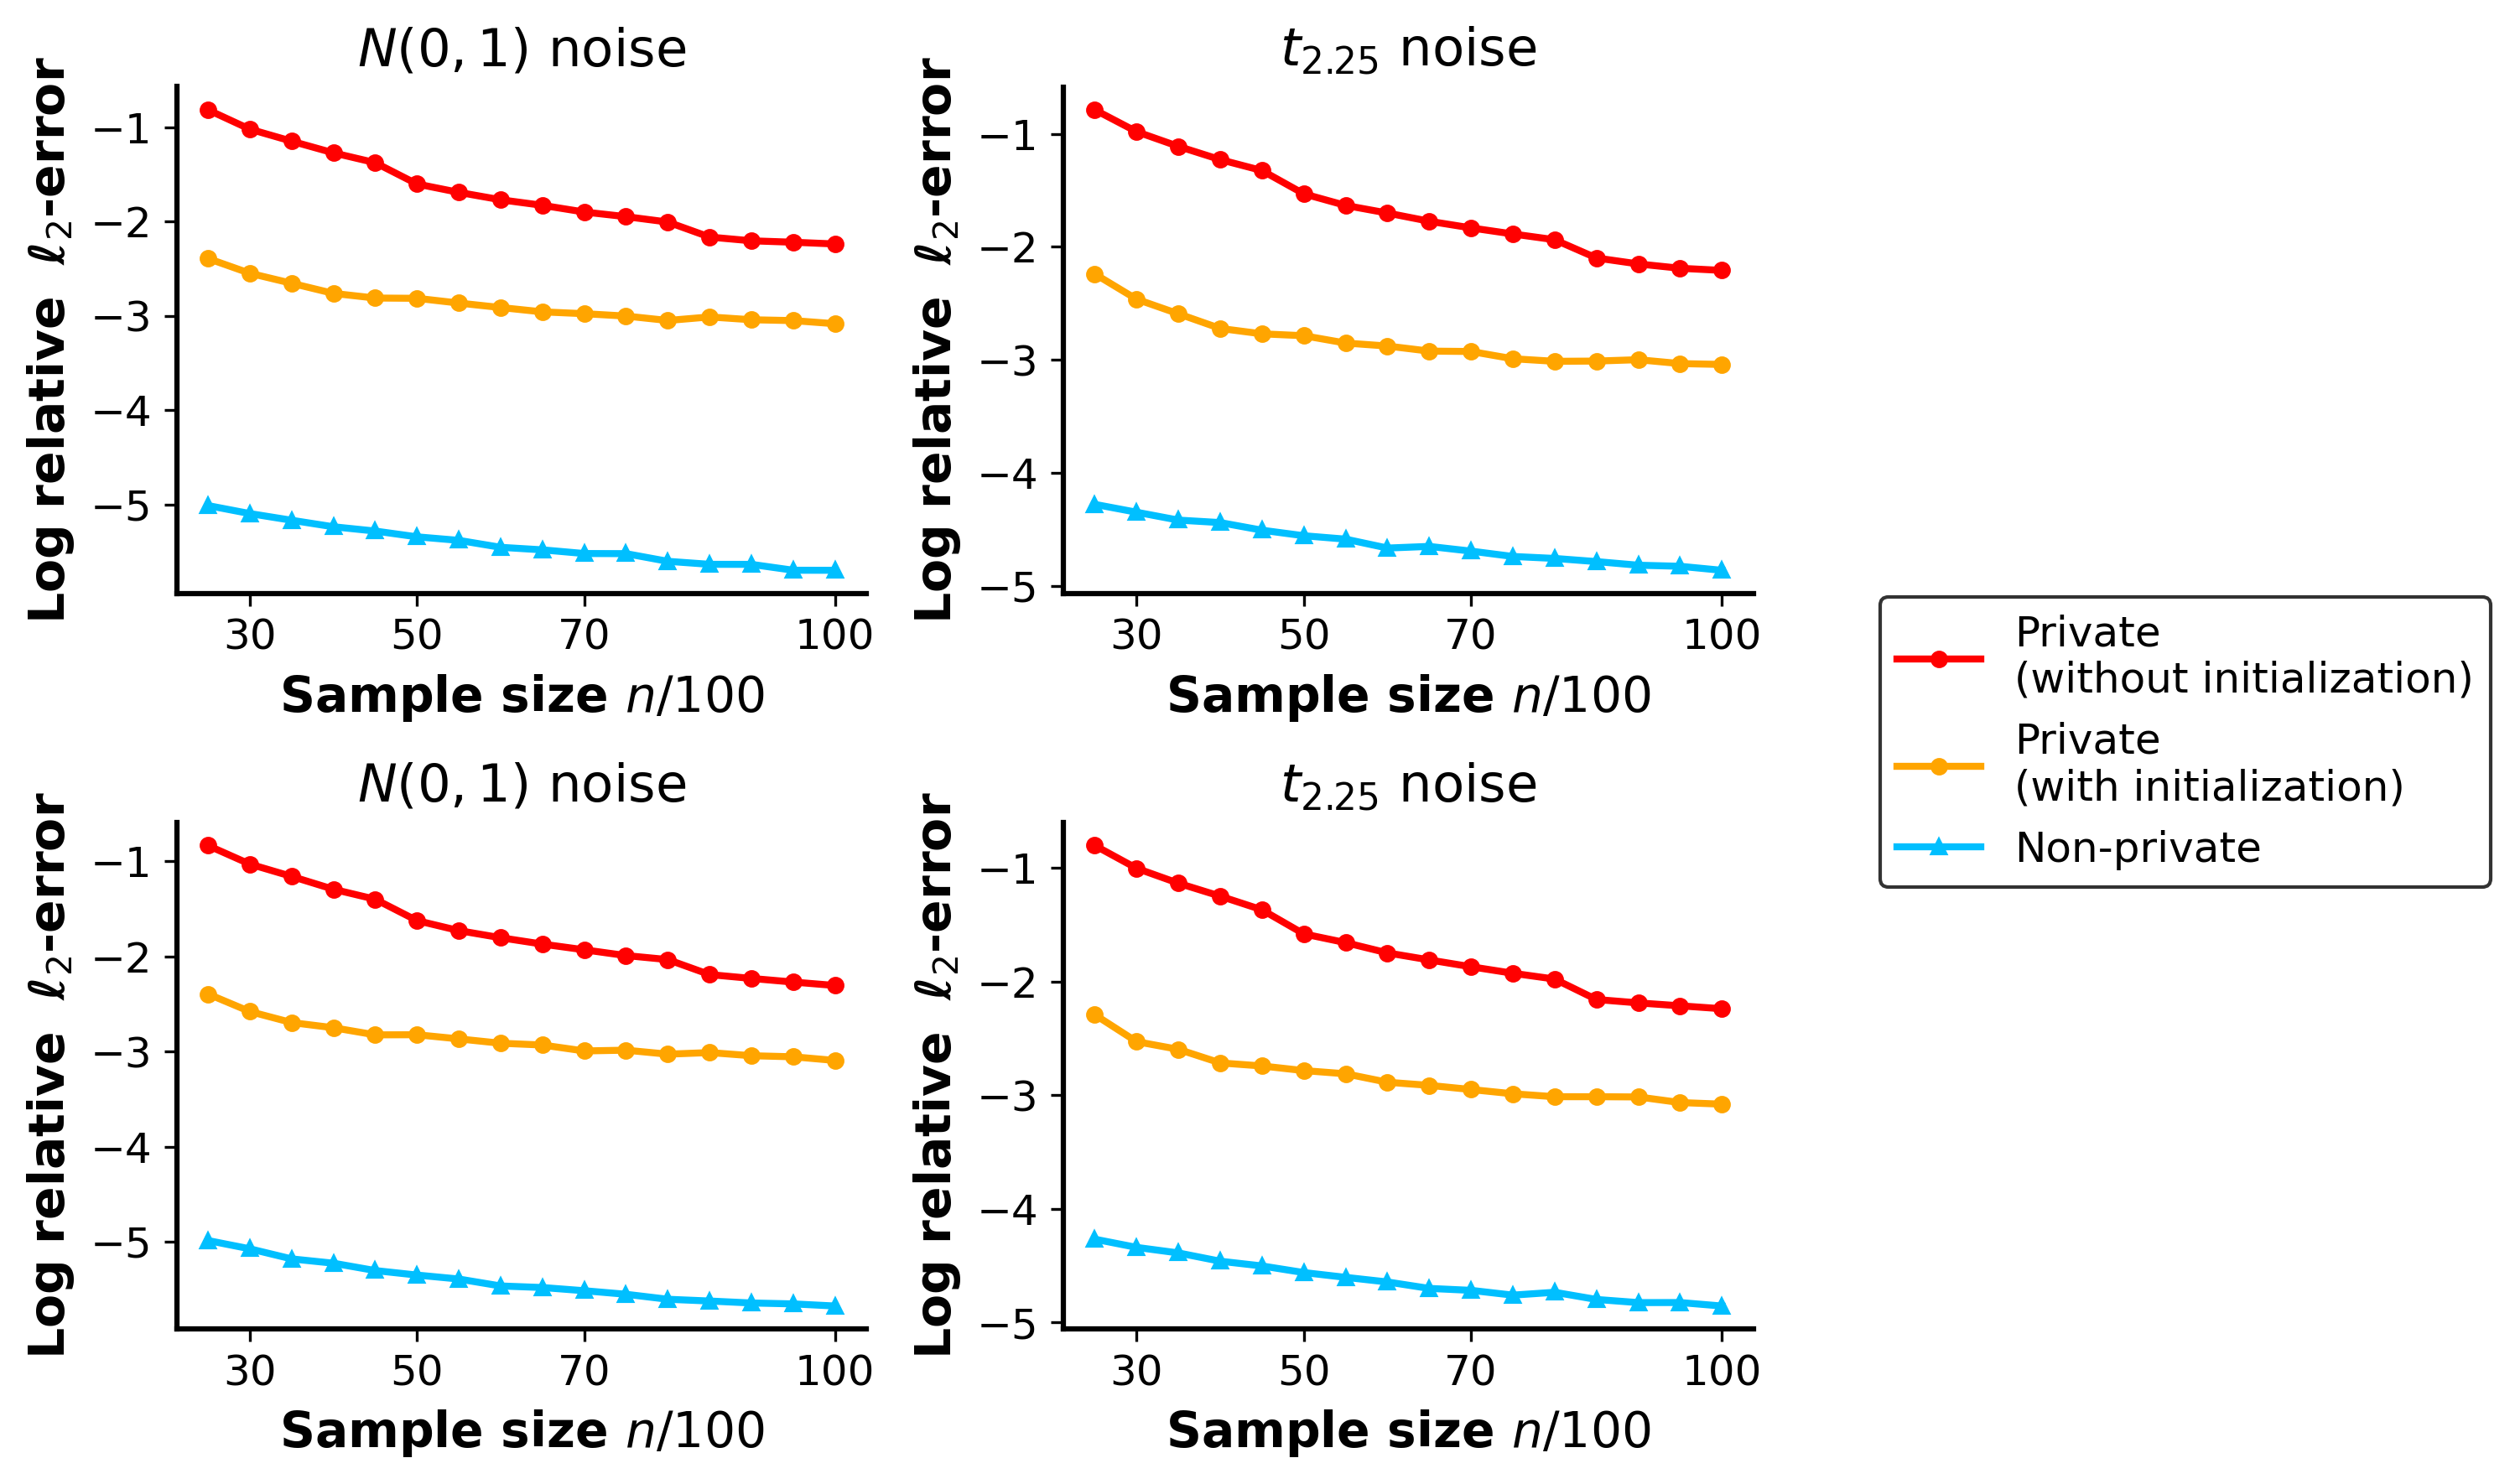

In [6]:
n_set = np.arange(2500, 10001, 500)
blocks = results_lowdim_init_array.reshape(4, len(n_set), 3)
fig_init = plot_l2_error_vs_n(blocks, n_set)
#fig_init.savefig("Est_low_init.png", dpi=300, bbox_inches='tight')

### 1.2. Different privacy levels

#### 1.2.1. Main function

In [ ]:
def main_lowdim_eps(n,p,a,b,Gaussian_covariate= True, Gaussian_error=True):
    # true beta
    rgt.seed(0) # set seed
    beta = a*np.ones(p)*(2*rgt.binomial(1, 0.5, size=p)-1) #  beta in {a,-a}  
    beta_norm = beta.dot(beta)**0.5 # the l2 norm of true beta
    
    #privacy parameters 
    epsilon = np.array([.3, .5, .9]) 
    delta = 10/( n**1.1)
    epsilon_init = epsilon/6  # privacy budget for initialization: 1/6
    delta_init = delta/6 
    epsilon_est = 5*epsilon/6 # privacy budget for estmation: 5/6
    delta_est = 5*delta/6 
    
    repetitions = 300 # number of repetitions 
    rela_l2  = np.zeros([  repetitions])  # relative l2-error results of the non-private estimate 
    priv_rela_l2_1 = np.zeros([  repetitions]) # relative l2-error results of the private estimate with epsilon = 0.3
    priv_rela_l2_2 = np.zeros([  repetitions]) # relative l2-error results of the private estimate with epsilon = 0.5
    priv_rela_l2_3 = np.zeros([  repetitions]) # relative l2-error results of the private estimate with epsilon = 0.9
    for m in range(repetitions):
        rgt.seed(m+10) # set seed
        
        ############################################  
        ############# generate data ################  
        ############################################  
        # X 
        if Gaussian_covariate == True: X = rgt.normal(0, 1, size=(n,p-1)) 
        else: X = rgt.uniform(-np.sqrt(3),np.sqrt(3), size=(n,p-1))
        # error
        if Gaussian_error == True: err = rgt.normal(0,1, n)
        else: err = rgt.standard_t(2.25, n) 
        # Y
        Y = beta[0] + X.dot(beta[1:]) +    np.sqrt(b)*  err 

        
        ############################################### 
        #-------------  Private (proposed)  ----------- 
        ###############################################  
        
        #---- initialization ----
        epsilon_tau =  epsilon_init/4  # privacy budget for DP standard deviation estimation: 1/4
        epsilon_ridge =  3*epsilon_init/4 # privacy budget for DP huber+ridge estimation: 3/4
        tau_init_1 =   St_DP(Y, epsilon = epsilon_tau[0])   
        beta_0DP_1 =  huber_ridge_priv(X, Y, tau=tau_init_1, epsilon= epsilon_ridge[0], delta= delta_init) 
        tau_init_2 =   St_DP(Y, epsilon = epsilon_tau[1])   
        beta_0DP_2 =  huber_ridge_priv(X, Y, tau=tau_init_2, epsilon= epsilon_ridge[1], delta= delta_init) 
        tau_init_3 =   St_DP(Y, epsilon = epsilon_tau[2])   
        beta_0DP_3 =  huber_ridge_priv(X, Y, tau=tau_init_3, epsilon= epsilon_ridge[2], delta= delta_init) 

        #---- estimation ---- 
        gamma = 0.5*(p + np.log(n))**0.5
        T = int(np.ceil(2*np.log(n)))
        sigma_scale = compute_sigma_scale(T, gamma, epsilon_est, delta_est)
        tau_priv_1 = .04* tau_init_1 * (n * epsilon[0]  /(p+np.log(n)))**0.5
        tau_priv_2 = .04* tau_init_2 * (n * epsilon[1]  /(p+np.log(n)))**0.5
        tau_priv_3 = .04* tau_init_3 * (n * epsilon[2]  /(p+np.log(n)))**0.5   
        lr  =  0.2 # learning rate  
        model = Huber(X, Y,intercept=True) 
        out_priv_1 = model.noisygd(tau=tau_priv_1, lr= lr, beta0=beta_0DP_1, B=gamma , sigma_scale=sigma_scale[0],T=T) 
        out_priv_2 = model.noisygd(tau=tau_priv_2, lr= lr, beta0=beta_0DP_2, B=gamma , sigma_scale=sigma_scale[1],T=T) 
        out_priv_3 = model.noisygd(tau=tau_priv_3, lr= lr, beta0=beta_0DP_3, B=gamma , sigma_scale=sigma_scale[2],T=T) 
        priv_rela_l2_1[m] = np.log(np.sum((out_priv_1['beta']  - beta )**2 )**0.5  / beta_norm)
        priv_rela_l2_2[m] = np.log(np.sum((out_priv_2['beta']  - beta )**2 )**0.5  / beta_norm)
        priv_rela_l2_3[m] = np.log(np.sum((out_priv_3['beta']  - beta )**2 )**0.5  / beta_norm)
          
        
        ############################################### 
        #----------------  Non-private  --------------- 
        ###############################################
        model = Huber(X, Y,intercept=True)
        tau0 = np.sqrt(np.mean(Y**2)-(np.mean(Y)**2))
        tau_np = .2*tau0 * (n/(p+np.log(n)))**0.5     
        out  = model.gd(tau=tau_np,  lr = 0.5, beta0= np.array([]), T=T)   
        rela_l2[m] = np.log(np.sum((out['beta']  - beta )**2 )**0.5  / beta_norm) 
            
    return np.array([priv_rela_l2_1,priv_rela_l2_2,priv_rela_l2_3,rela_l2])

In [17]:
# test
re_lowdim_eps = main_lowdim_eps(n=5000,p=5,a=2,b=0.5,Gaussian_covariate= True, Gaussian_error=True) 
#print(np.mean(re_lowdim_eps,axis=1))

#### 1.2.2. Main function adapted for parallel computing

In [ ]:
def main_lowdim_eps_parallel(m ):
    n_set = np.array([2500,5000,10000]) 
    p_set = np.array([10]) 
    a_set = np.array([2]) 
    b_set = np.array([0.5]) 
    TF_set = np.array([True, False])  
    results = []
    for T1 in TF_set:
        for T2 in TF_set: 
            for p in p_set: 
                for a in a_set:
                    for b in b_set:
                        for n in n_set: 
                            # true beta
                            rgt.seed(0) # set seed
                            beta = a*np.ones(p)*(2*rgt.binomial(1, 0.5, size=p)-1) #   beta in {a,-a}  
                            beta_norm = beta.dot(beta)**0.5 # the l2 norm of true beta
                            
                            #privacy parameters 
                            epsilon = np.array([.3,.5,.9]) 
                            delta = 10/( n**1.1)
                            epsilon_init = epsilon/6  # privacy budget for initialization: 1/6
                            delta_init = delta/6 
                            epsilon_est = 5*epsilon/6 # privacy budget for estmation: 5/6
                            delta_est = 5*delta/6 
                        
                            rgt.seed(m+10) # set seed

                            ############################################  
                            ############# generate data ################  
                            ############################################  
                            # X 
                            if T1 == True: X = rgt.normal(0, 1, size=(n,p-1)) 
                            else: X = rgt.uniform(-np.sqrt(3),np.sqrt(3), size=(n,p-1))
                            # error
                            if T2 == True: err = rgt.normal(0,1, n)
                            else: err = rgt.standard_t(2.25, n) 
                            # Y
                            Y = beta[0] + X.dot(beta[1:]) +    np.sqrt(b)*  err  
                             

                            ############################################### 
                            #-------------  Private (proposed)  ----------- 
                            ###############################################      
                                  
                            #---- initialization ----
                            epsilon_tau =  epsilon_init/4  # privacy budget for DP standard deviation estimation: 1/4
                            epsilon_ridge =  3*epsilon_init/4 # privacy budget for DP huber+ridge estimation: 3/4
                            tau_init_1 =   St_DP(Y, epsilon = epsilon_tau[0])   
                            beta_0DP_1 =  huber_ridge_priv(X, Y, tau=tau_init_1, epsilon= epsilon_ridge[0], delta= delta_init) 
                            tau_init_2 =   St_DP(Y, epsilon = epsilon_tau[1])   
                            beta_0DP_2 =  huber_ridge_priv(X, Y, tau=tau_init_2, epsilon= epsilon_ridge[1], delta= delta_init) 
                            tau_init_3 =   St_DP(Y, epsilon = epsilon_tau[2])   
                            beta_0DP_3 =  huber_ridge_priv(X, Y, tau=tau_init_3, epsilon= epsilon_ridge[2], delta= delta_init) 

                            #---- estimation ---- 
                            gamma = 0.5*(p + np.log(n))**0.5
                            T = int(np.ceil(2*np.log(n)))
                            sigma_scale = compute_sigma_scale(T, gamma, epsilon_est, delta_est)
                            tau_priv_1 = .04* tau_init_1 * (n * epsilon[0]  /(p+np.log(n)))**0.5
                            tau_priv_2 = .04* tau_init_2 * (n * epsilon[1]  /(p+np.log(n)))**0.5
                            tau_priv_3 = .04* tau_init_3 * (n * epsilon[2]  /(p+np.log(n)))**0.5   
                            lr  =  0.2 # learning rate  
                            model = Huber(X, Y,intercept=True) 
                            out_priv_1 = model.noisygd(tau=tau_priv_1, lr= lr, beta0=beta_0DP_1, B=gamma , sigma_scale=sigma_scale[0],T=T) 
                            out_priv_2 = model.noisygd(tau=tau_priv_2, lr= lr, beta0=beta_0DP_2, B=gamma , sigma_scale=sigma_scale[1],T=T) 
                            out_priv_3 = model.noisygd(tau=tau_priv_3, lr= lr, beta0=beta_0DP_3, B=gamma , sigma_scale=sigma_scale[2],T=T) 
                            priv_rela_l2_1 = np.log(np.sum((out_priv_1['beta']  - beta )**2 )**0.5  / beta_norm)
                            priv_rela_l2_2 = np.log(np.sum((out_priv_2['beta']  - beta )**2 )**0.5  / beta_norm)
                            priv_rela_l2_3 = np.log(np.sum((out_priv_3['beta']  - beta )**2 )**0.5  / beta_norm)
                            
                            
                            ############################################### 
                            #----------------  Non-private  --------------- 
                            ###############################################  
                            model = Huber(X, Y,intercept=True)
                            tau0 = np.sqrt(np.mean(Y**2)-(np.mean(Y)**2))
                            tau_np = .2*tau0 * (n/(p+np.log(n)))**0.5   
                            out  = model.gd(tau=tau_np,  lr=0.5 , beta0= np.array([]), T=T)   
                            rela_l2 = np.log(np.sum((out['beta']  - beta )**2 )**0.5  / beta_norm) 
                            
                            re_all = np.array([priv_rela_l2_1,priv_rela_l2_2,priv_rela_l2_3,rela_l2])
                            results.append(re_all)
        
    return results

In [12]:
# test 12 mins
cuda_cores = 20
M = 300
re_lowdim_eps_parallel = np.array(Parallel(n_jobs=cuda_cores)(delayed(main_lowdim_eps_parallel)(m ) for m in tqdm(range(M)))) 

  0%|          | 0/300 [00:00<?, ?it/s]

##### Plot function

In [13]:
def plot_eps_boxplots(re_lowdim_eps_parallel, n_set):
    """
    Boxplots of log relative L2 error across M replications.

    Parameters
    ----------
    re_lowdim_eps_parallel : array_like, shape (M, 12, 4)
        Monte Carlo results. The middle dimension corresponds to
        4 scenarios × 3 sample sizes (n_set), and the last dimension
        corresponds to 4 methods:
            0: DP, epsilon = 0.3
            1: DP, epsilon = 0.5
            2: DP, epsilon = 0.9
            3: Non-private.
    n_set : array_like, shape (3,)
        Sample sizes, e.g. [2500, 5000, 10000].
    """
    arr = np.asarray(re_lowdim_eps_parallel)
    n_set = np.asarray(n_set)

    M, combos, n_methods = arr.shape
    assert len(n_set) == 3, "This plotting function assumes 3 sample sizes."
    assert combos == 4 * len(n_set), "Middle dimension must be 4 scenarios × len(n_set)."
    assert n_methods == 4, "The last dimension must be 4 methods."

    # Reshape to (M, 4 scenarios, 3 ns, 4 methods)
    arr4 = arr.reshape(M, 4, len(n_set), 4)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=300)
    axs = axs.flatten()

    titles = [
        r'$N(0,1)~{\rm noise}$',
        r'$t_{2.25}~{\rm noise}$',
        r'$N(0,1)~{\rm noise}$',
        r'$t_{2.25}~{\rm noise}$'
    ]

    # Colors for the 4 methods (3 DP + 1 non-private)
    method_colors = {
        0: 'seagreen',   # DP, epsilon = 0.3
        1: 'orange',     # DP, epsilon = 0.5
        2: 'red',        # DP, epsilon = 0.9
        3: 'deepskyblue' # Non-private
    }

    method_labels = {
        0: 'epsilon = 0.3',
        1: 'epsilon = 0.5',
        2: 'epsilon = 0.9',
        3: 'Non-private'
    }

    num_n = len(n_set)
    num_methods = 4

    # Group positions for boxplots
    group_width = num_methods + 1.0   # spacing between groups
    group_centers = np.arange(num_n) * group_width

    for scen_idx in range(4):
        ax = axs[scen_idx]

        # Collect boxplot data and positions
        box_data = []
        box_positions = []

        for k in range(num_n):  # loop over n_set
            for m_idx in range(num_methods):
                vals = arr4[:, scen_idx, k, m_idx]
                box_data.append(vals)

                pos = group_centers[k] + m_idx  # offset inside each group
                box_positions.append(pos)

        # Draw boxplots
        bp = ax.boxplot(
            box_data,
            positions=box_positions,
            widths=0.6,
            patch_artist=True,
            showfliers=False
        )

        # Color each box according to method
        for i, patch in enumerate(bp['boxes']):
            m_idx = i % num_methods
            patch.set_facecolor(method_colors[m_idx])
            patch.set_edgecolor('black')
            patch.set_alpha(0.7)

        # Color medians
        for median in bp['medians']:
            median.set_color('black')
            median.set_linewidth(1.2)

        # x-ticks at group centers, labeled by n
        ax.set_xticks(group_centers + (num_methods - 1) / 2.0)
        xtick_labels = [rf'$n={int(v)}$' for v in n_set]
        ax.set_xticklabels(xtick_labels)
        ax.set_xlabel('Sample size', fontsize=12, fontweight='bold')

        # Vertical dashed lines to separate groups (between groups)
        for k in range(num_n - 1):
            last_k = group_centers[k] + (num_methods - 1)
            first_k1 = group_centers[k+1]
            x_sep = 0.5 * (last_k + first_k1)
            ax.axvline(
                x=x_sep,
                color='grey',
                linestyle='--',
                linewidth=1,
                alpha=0.6,
                zorder=0
            )

        ax.set_ylabel(
            r'${\rm \mathbf{Log~relative~}}~ \boldsymbol{\ell}_2$-error',
            fontsize=12,
            fontweight='bold'
        )
        ax.set_title(titles[scen_idx], fontsize=13, fontweight='bold')

        # Keep only left and bottom spines
        ax.set_facecolor('white')
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.tick_params(axis='both', which='major', labelsize=10)

    # Legend: 4 methods
    legend_handles = [
        Line2D([0], [0], color=method_colors[i], lw=2)
        for i in range(num_methods)
    ]
    legend_labels = [method_labels[i] for i in range(num_methods)]

    legend = fig.legend(
        legend_handles,
        legend_labels,
        loc='center left',
        bbox_to_anchor=(0.93, 0.5),
        frameon=True,
        prop={'size': 11}
    )
    frame = legend.get_frame()
    frame.set_edgecolor('black')
    frame.set_linewidth(1)
    frame.set_facecolor('white')

    plt.tight_layout(rect=[0, 0, 0.88, 1])
    return fig

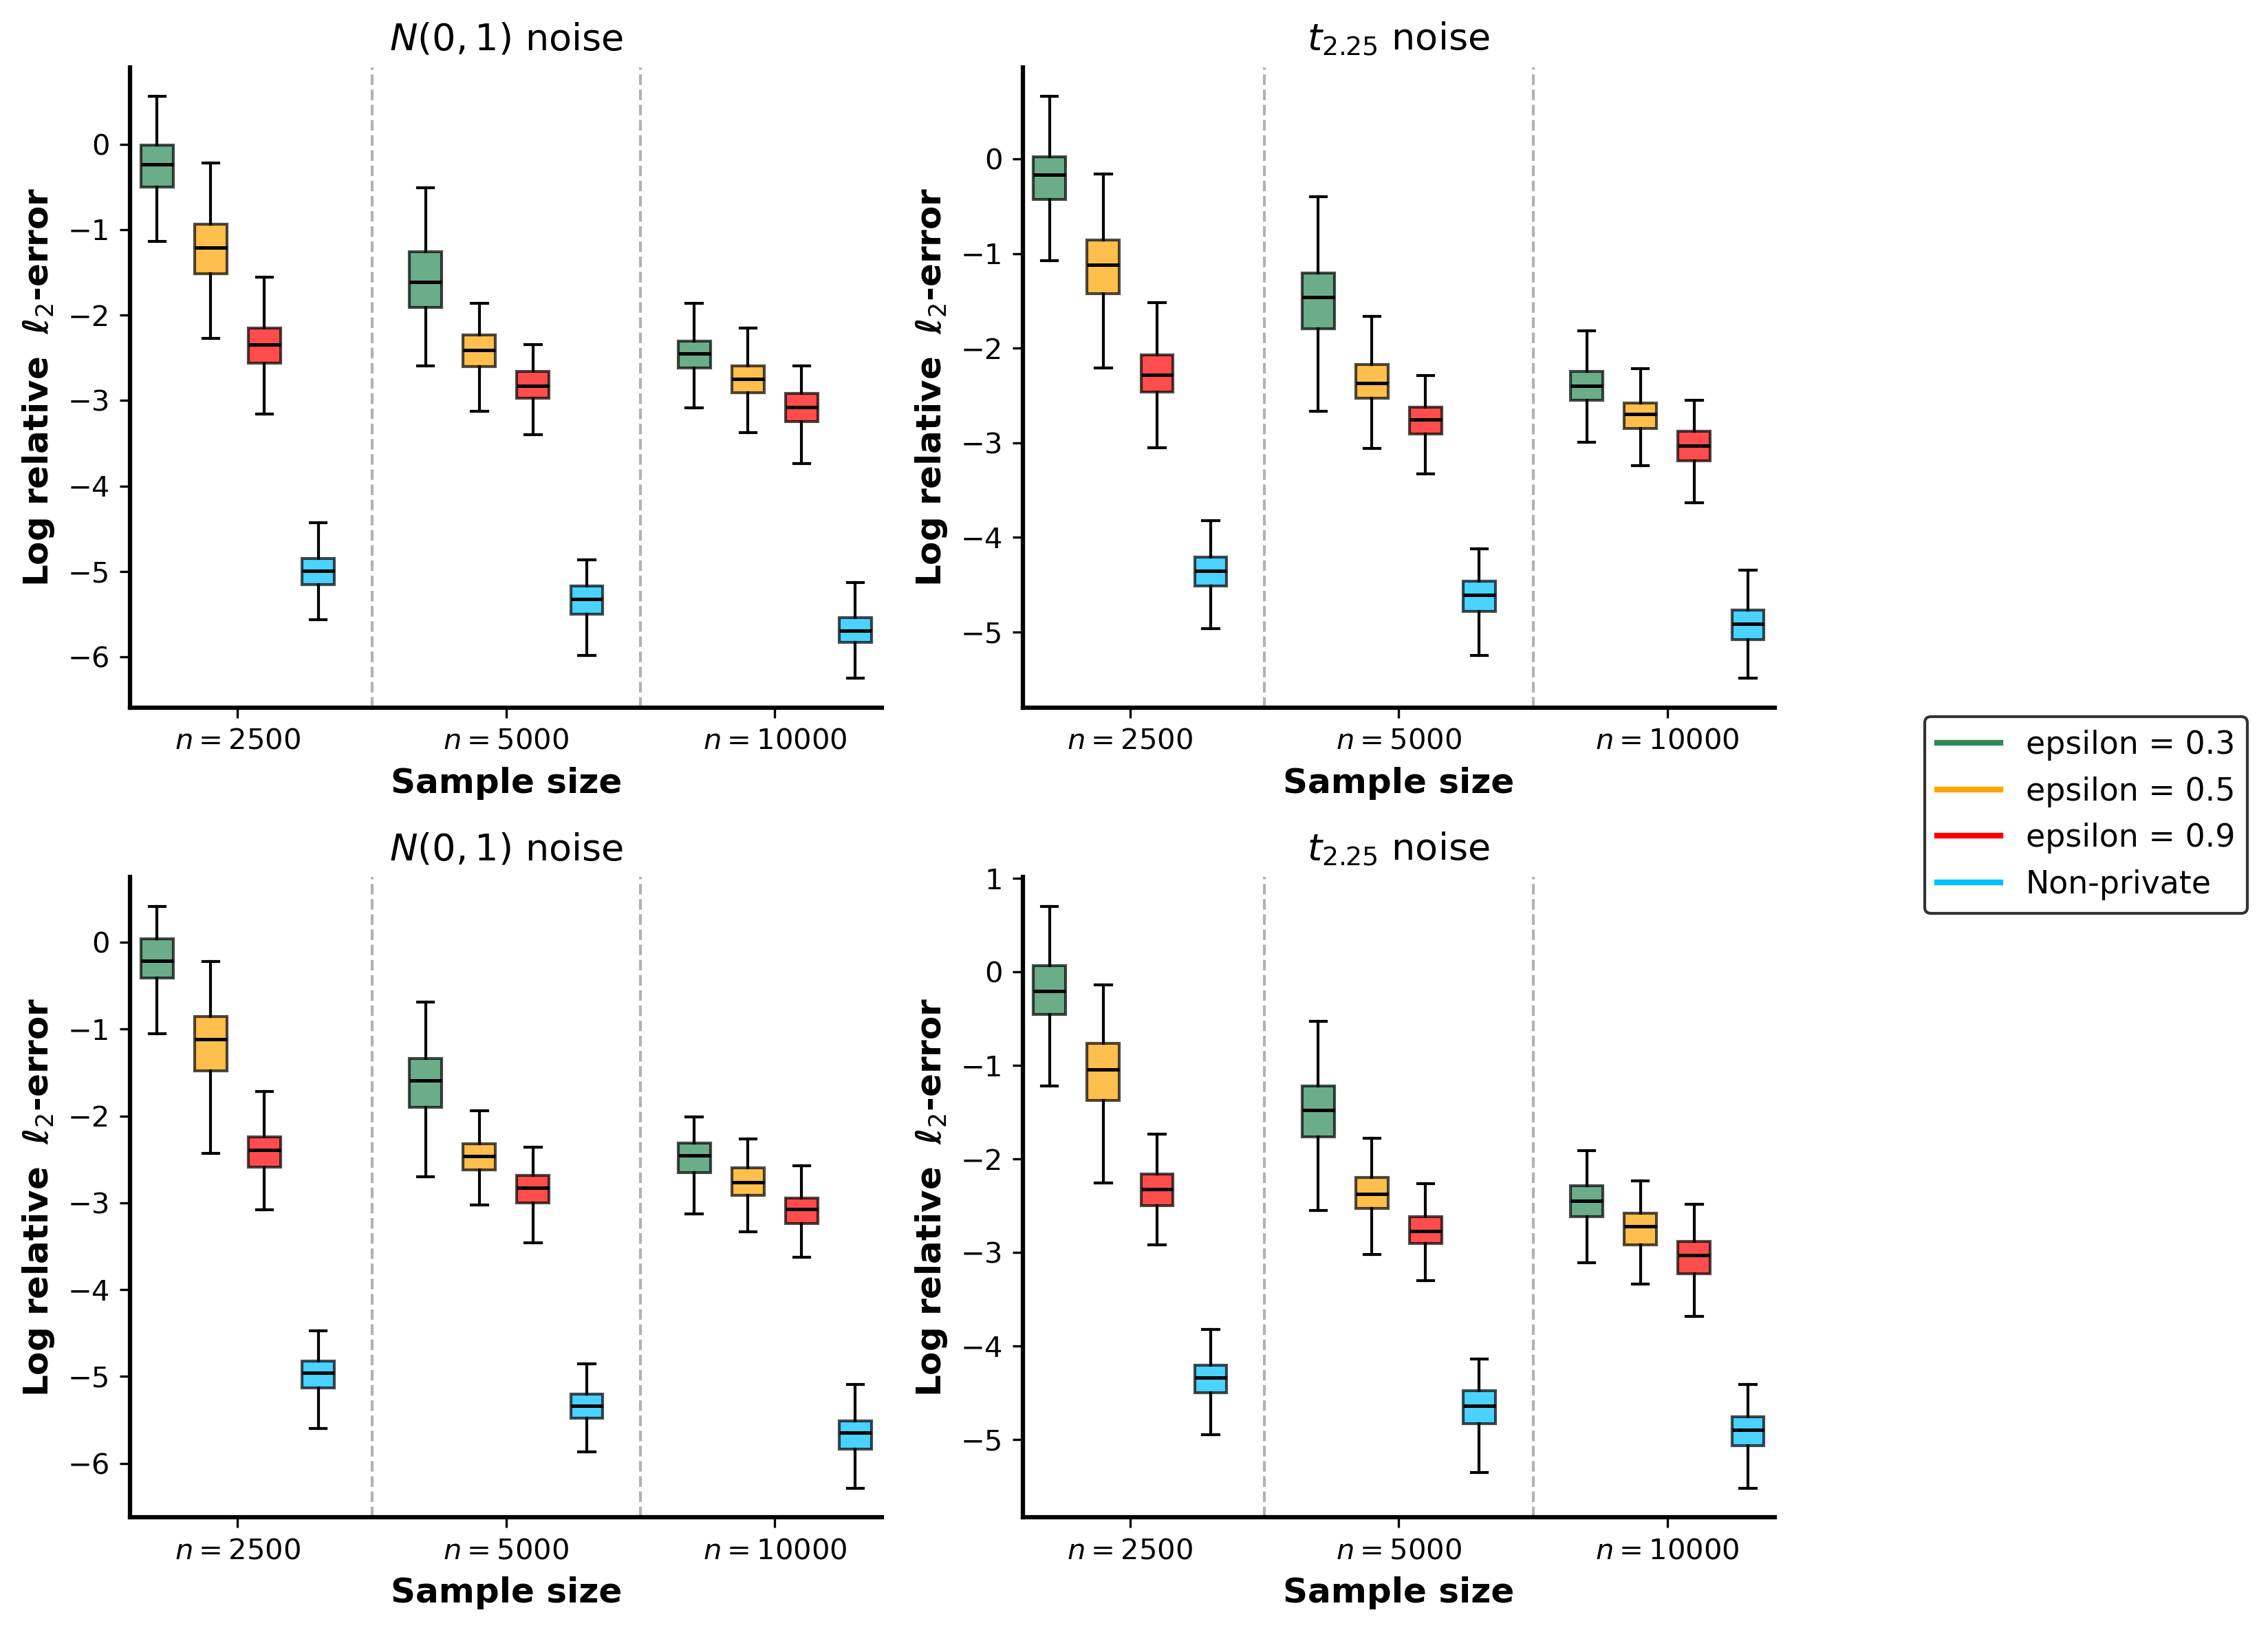

In [14]:
n_set = np.array([2500, 5000, 10000])
fig_eps = plot_eps_boxplots(re_lowdim_eps_parallel, n_set)
#fig_eps.savefig("Est_low_eps.png", dpi=300, bbox_inches='tight')

### 1.3. Different SNRs

#### 1.3.1 Main function adapted for parallel computing

In [ ]:
def main_lowdim_SNR_parallel(m ):
    n_set = np.array([ 2500,5000, 10000]) 
    p_set = np.array([5 ,10,20 ]) 
    a_set = np.array([ 0.5,1,2 ]) 
    b_set = np.array([0.5,1,2 ]) 
    TF_set = np.array([True, False])  
    results = []
    for T1 in TF_set:
        for T2 in TF_set: 
            for p in p_set: 
                for a in a_set:
                    for b in b_set:
                        for n in n_set: 
                            # true beta
                            rgt.seed(0) # set seed
                            beta = a*np.ones(p)*(2*rgt.binomial(1, 0.5, size=p)-1) #   beta: {a,-a,a,...}  
                            beta_norm = beta.dot(beta)**0.5 # the l2 norm of true beta
                            
                            #privacy parameters 
                            epsilon = np.array([.3,.5,.9]) 
                            delta = 10/( n**1.1)
                            epsilon_init = epsilon/6  # privacy budget for initialization: 1/6
                            delta_init = delta/6 
                            epsilon_est = 5*epsilon/6 # privacy budget for estmation: 5/6
                            delta_est = 5*delta/6 
                        
                            rgt.seed(m+10) # set seed

                            ############################################  
                            ############# generate data ################  
                            ############################################  
                            # X 
                            if T1 == True: X = rgt.normal(0, 1, size=(n,p-1)) 
                            else: X = rgt.uniform(-np.sqrt(3),np.sqrt(3), size=(n,p-1))
                            # error
                            if T2 == True: err = rgt.normal(0,1, n)
                            else: err = rgt.standard_t(2.25, n) 
                            # Y
                            Y = beta[0] + X.dot(beta[1:]) +    np.sqrt(b)*  err  
                             

                            ############################################### 
                            #-------------  Private (proposed)  ----------- 
                            ###############################################      
                                  
                            #---- initialization ----
                            epsilon_tau =  epsilon_init/4  # privacy budget for DP standard deviation estimation: 1/4
                            epsilon_ridge =  3*epsilon_init/4 # privacy budget for DP huber+ridge estimation: 3/4
                            tau_init_1 =   St_DP(Y, epsilon = epsilon_tau[0])   
                            beta_0DP_1 =  huber_ridge_priv(X, Y, tau=tau_init_1, epsilon= epsilon_ridge[0], delta= delta_init) 
                            tau_init_2 =   St_DP(Y, epsilon = epsilon_tau[1])   
                            beta_0DP_2 =  huber_ridge_priv(X, Y, tau=tau_init_2, epsilon= epsilon_ridge[1], delta= delta_init) 
                            tau_init_3 =   St_DP(Y, epsilon = epsilon_tau[2])   
                            beta_0DP_3 =  huber_ridge_priv(X, Y, tau=tau_init_3, epsilon= epsilon_ridge[2], delta= delta_init) 

                            #---- estimation ---- 
                            gamma = 0.5*(p + np.log(n))**0.5
                            T = int(np.ceil(2*np.log(n)))
                            sigma_scale = compute_sigma_scale(T, gamma, epsilon_est, delta_est)
                            tau_priv_1 = .04* tau_init_1 * (n * epsilon[0]  /(p+np.log(n)))**0.5
                            tau_priv_2 = .04* tau_init_2 * (n * epsilon[1]  /(p+np.log(n)))**0.5
                            tau_priv_3 = .04* tau_init_3 * (n * epsilon[2]  /(p+np.log(n)))**0.5   
                            lr  =  0.2 # learning rate 
                            model = Huber(X, Y,intercept=True) 
                            out_priv_1 = model.noisygd(tau=tau_priv_1, lr= lr, beta0=beta_0DP_1, B=gamma , sigma_scale=sigma_scale[0],T=T) 
                            out_priv_2 = model.noisygd(tau=tau_priv_2, lr= lr, beta0=beta_0DP_2, B=gamma , sigma_scale=sigma_scale[1],T=T) 
                            out_priv_3 = model.noisygd(tau=tau_priv_3, lr= lr, beta0=beta_0DP_3, B=gamma , sigma_scale=sigma_scale[2],T=T) 
                            priv_rela_l2_1 = np.log(np.sum((out_priv_1['beta']  - beta )**2 )**0.5  / beta_norm)
                            priv_rela_l2_2 = np.log(np.sum((out_priv_2['beta']  - beta )**2 )**0.5  / beta_norm)
                            priv_rela_l2_3 = np.log(np.sum((out_priv_3['beta']  - beta )**2 )**0.5  / beta_norm)
                            
                            
                            ############################################### 
                            #----------------  Non-private  --------------- 
                            ###############################################  
                            model = Huber(X, Y,intercept=True)
                            tau0 = np.sqrt(np.mean(Y**2)-(np.mean(Y)**2)) 
                            tau_np = .2 *tau0* (n/(p+np.log(n)))**0.5   
                            out  = model.gd(tau=tau_np,  lr= 0.5 , beta0= np.array([]), T=T)   
                            rela_l2 = np.log(np.sum((out['beta']  - beta )**2 )**0.5  / beta_norm) 
                            
                            re_all = np.array([rela_l2,priv_rela_l2_1,priv_rela_l2_2,priv_rela_l2_3 ])
                            results.append(re_all)
        
    return results

In [32]:
# test 6 hours
cuda_cores = 20
M = 300
re_SNR = np.array(Parallel(n_jobs=cuda_cores)(delayed(main_lowdim_SNR_parallel)(m ) for m in tqdm(range(M))))
results_SNR_array = np.mean(re_SNR, axis=0)
#print(results_SNR_array)

  0%|          | 0/300 [00:00<?, ?it/s]

In [33]:
import pandas as pd
df = pd.DataFrame(results_SNR_array) 
df.to_csv("results_lowdim.csv", index=False)

## 2. Converge results

### 2.1. Main function

In [ ]:
def main_CI(n=10000,p=5,a=1,b=1,alpha=0.05,Gaussian_covariate= True, Gaussian_error=False): 
    # true beta
    rgt.seed(0) # set seed
    beta = a*np.ones(p)*(2*rgt.binomial(1, 0.5, size=p)-1) # beta in {a,-a}    
    
    #privacy parameters
    epsilon = .5  
    delta = 10/(n**1.1)
    epsilon_init = epsilon/6  # privacy budget for initialization: 1/6
    delta_init = delta/6 
    epsilon_est = 2*epsilon/3 # privacy budget for estmation: 4/6
    delta_est = 2*delta/3
    epsilon_infer = epsilon/6 # privacy budget for inference: 1/6
    delta_infer = delta/6
 
    repetitions = 300 # number of repetitions
    cover_re = np.zeros([p, repetitions])  # coverage of  the non-private estimate
    width_re = np.zeros([p, repetitions]) # width 
    priv_cover_re = np.zeros([p, repetitions])  # coverage of  the private estimate
    priv_width_re = np.zeros([p, repetitions]) # width   

    for m in range(repetitions):
        rgt.seed(m+10) # set seed
        
        ############################################  
        ############# generate data ################  
        ############################################  
        # X 
        if Gaussian_covariate == True: X = rgt.normal(0, 1, size=(n,p-1)) 
        else: X = rgt.uniform(-np.sqrt(3),np.sqrt(3), size=(n,p-1))
        # error
        if Gaussian_error == True: err = rgt.normal(0,1, n)
        else: err = rgt.standard_t(2.25, n) 
        # Y
        Y = beta[0] + X.dot(beta[1:]) +    np.sqrt(b)*  err
        
        ############################################### 
        #-------------  Private (proposed)  ----------- 
        ###############################################  
        
        #---- initialization ----
        epsilon_tau =  epsilon_init/4  # privacy budget for DP standard deviation estimation: 1/4
        epsilon_ridge =  3*epsilon_init/4 # privacy budget for DP huber+ridge estimation: 3/4
        tau_init =   St_DP(Y, epsilon = epsilon_tau)   
        beta_0DP =  huber_ridge_priv(X, Y, tau=tau_init, epsilon= epsilon_ridge, delta= delta_init) 

        #---- estimation ---- 
        gamma = 0.5*(p + np.log(n))**0.5
        T = int(np.ceil(2*np.log(n)))
        sigma_scale = compute_sigma_scale(T, gamma, epsilon_est, delta_est)
        tau_priv = .04* tau_init * (n * epsilon  /(p+np.log(n)))**0.5   
        lr  =  0.2 # learning rate  
        model = Huber(X, Y,intercept=True)
        out = model.noisygd( tau = tau_priv, lr= lr, beta0=beta_0DP, B=gamma , sigma_scale=sigma_scale,T=T)
        betaT = out['beta']   
        
        #---- inference ----
        tau_new =  0.95*tau_init * (n *epsilon /((p+np.log(n))))**0.5 
        gamma_new = gamma
        X_inter = np.concatenate([np.ones((n,1)), X], axis=1) 
        tilde_Xi = hatXi_DP_priv(X=X_inter, Y=Y,beta= betaT, gamma= gamma_new, tau_new=tau_new,epsilon=epsilon_infer,delta=delta_infer)  
        diag_elements = np.sqrt(np.diag(tilde_Xi))
        z_alpha2 = norm.ppf(1-alpha/2)
        dis_vec = z_alpha2*diag_elements/np.sqrt(n) 
        CI_low = betaT - dis_vec
        CI_high = betaT + dis_vec  
        priv_cover_re[:,m] = (beta >= CI_low) & (beta <= CI_high)
        priv_width_re[:,m] = 2*dis_vec 


        ############################################### 
        #----------------  Non-private  --------------- 
        ############################################### 
        #---- estimation ---- 
        model = Huber(X, Y,intercept=True)
        tau0 = np.sqrt(np.mean(Y**2)-(np.mean(Y)**2))
        tau_np = .2 *tau0* (n/(p+np.log(n)))**0.5   
        out0 = model.gd(tau=tau_np,  lr= 0.5 , beta0= np.array([]), T=T) 
        betaT0 = out0['beta']
        resT0 = out0['residuals']
        
        #---- inference ----
        tau_new_np = .5  *mad(resT0) * (n/(p+np.log(n)))**0.5
        X_inter = np.concatenate([np.ones((n,1)), X], axis=1) 
        tilde_Xi0 = hatXi(X=X_inter, Y=Y, beta = betaT0, tau_new=tau_new_np ) 
        diag_elements0 = np.sqrt(np.diag(tilde_Xi0))
        z_alpha2 = norm.ppf(1-alpha/2)
        dis_vec0 = z_alpha2*diag_elements0/np.sqrt(n) 
        CI_low0 = betaT0 - dis_vec0
        CI_high0 = betaT0 + dis_vec0 
        cover_re[:,m] = (beta >= CI_low0) & (beta <= CI_high0)
        width_re[:,m] = 2*dis_vec0  # width 
 

    return  priv_cover_re,priv_width_re,cover_re,width_re 

In [28]:
# test
re_CI = main_CI(n=10000,p=5,a=1,b=1,alpha=0.05,Gaussian_covariate= True, Gaussian_error=True) 
#print(np.array([np.mean(re_CI[0]),np.mean(re_CI[1]),np.std(np.mean(re_CI[1],axis=1)),np.mean(re_CI[2]),np.mean(re_CI[3]),np.std(np.mean(re_CI[3],axis=1))]))

### 2.2. Main function adapted for parallel computing

In [ ]:
def main_CI_parallel(m): 
    n=10000
    p=5
    a=1
    b=1
    alpha_set = np.array([  0.05,0.1 ])
    TF_set = np.array([ True  ,False   ])   
    results = []
    for alpha in alpha_set:
        for T1 in TF_set:
            for T2 in TF_set: 
                # true beta
                rgt.seed(0) # set seed
                beta = a*np.ones(p)*(2*rgt.binomial(1, 0.5, size=p)-1) #   beta: {a,-a,a,...}     
                
                rgt.seed(m+10) # set seed
                
                ############################################  
                ############# generate data ################  
                ############################################  
                # X 
                if T1==True: X = rgt.normal(0, 1, size=(n,p-1)) 
                else: X = rgt.uniform(-np.sqrt(3),np.sqrt(3), size=(n,p-1))
                # error
                if T2==True: err = rgt.normal(0,1, n)
                else: err = rgt.standard_t(2.25, n) 
                # Y
                Y = beta[0] + X.dot(beta[1:]) +    np.sqrt(b)*  err
                
                ############################################### 
                #-------------  Private (proposed)  ----------- 
                ############################################### 

                #---- privacy budget allocation  
                epsilon = .5 
                delta = 10/( n**1.1)
                epsilon_init = epsilon/6  # privacy budget for initialization: 1/6
                delta_init = delta/6 
                epsilon_est = 2*epsilon/3 # privacy budget for estmation: 4/6
                delta_est = 2*delta/3
                epsilon_infer = epsilon/6 # privacy budget for inference: 1/6
                delta_infer = delta/6
                
                #---- initialization ----
                epsilon_tau =  epsilon_init/4  # privacy budget for DP standard deviation estimation: 1/4
                epsilon_ridge =  3*epsilon_init/4 # privacy budget for DP huber+ridge estimation: 3/4
                tau_init =   St_DP(Y, epsilon = epsilon_tau)   
                beta_0DP =  huber_ridge_priv(X, Y, tau=tau_init, epsilon= epsilon_ridge, delta= delta_init) 

                #---- estimation ---- 
                gamma = 0.5*(p + np.log(n))**0.5
                T = int(np.ceil(2*np.log(n)))
                sigma_scale = compute_sigma_scale(T, gamma, epsilon_est, delta_est)
                tau_priv = .04* tau_init * (n * epsilon  /(p+np.log(n)))**0.5   
                lr  =  0.2 # learning rate for both private and non-private estimations
                model = Huber(X, Y,intercept=True)
                out = model.noisygd(tau=tau_priv, lr= lr, beta0=beta_0DP, B=gamma , sigma_scale=sigma_scale,T=T)
                betaT = out['beta']   
                
                #---- inference ----
                tau_new =  0.95*tau_init * (n *epsilon  /((p+np.log(n))))**0.5 
                gamma_new = gamma
                X_inter = np.concatenate([np.ones((n,1)), X], axis=1) 
                tilde_Xi = hatXi_DP_priv(X=X_inter, Y=Y,beta= betaT, gamma= gamma_new, tau_new=tau_new,epsilon=epsilon_infer,delta=delta_infer)  
                diag_elements = np.sqrt(np.diag(tilde_Xi))
                z_alpha2 = norm.ppf(1-alpha/2)
                dis_vec = z_alpha2*diag_elements/np.sqrt(n) 
                CI_low = betaT - dis_vec
                CI_high = betaT + dis_vec  
                priv_cover_re = (beta >= CI_low) & (beta <= CI_high)
                priv_width_re = 2*dis_vec 


                ############################################### 
                #----------------  Non-private  --------------- 
                ############################################### 
                #---- estimation ---- 
                model = Huber(X, Y,intercept=True)
                tau0 = np.sqrt(np.mean(Y**2)-(np.mean(Y)**2)) 
                tau_np = .2 *tau0* (n/(p+np.log(n)))**0.5  
                out0 = model.gd(tau=tau_np,  lr= 0.5 , beta0=np.array([]), T=T) 
                betaT0 = out0['beta']
                resT0 = out0['residuals']
                
                #---- inference ----
                tau_new_np = 0.5  * mad(resT0) * (n/(p+np.log(n)))**0.5
                X_inter = np.concatenate([np.ones((n,1)), X], axis=1) 
                tilde_Xi0 = hatXi(X=X_inter, Y=Y, beta = betaT0, tau_new=tau_new_np ) 
                diag_elements0 = np.sqrt(np.diag(tilde_Xi0))
                z_alpha2 = norm.ppf(1-alpha/2)
                dis_vec0 = z_alpha2*diag_elements0/np.sqrt(n) 
                CI_low0 = betaT0 - dis_vec0
                CI_high0 = betaT0 + dis_vec0 
                cover_re = (beta >= CI_low0) & (beta <= CI_high0)
                width_re = 2*dis_vec0  # width 

                re_all = np.array([priv_cover_re,priv_width_re,cover_re,width_re]) 
                results.append(re_all)
                
    return  results

In [20]:
# test  4 mins
cuda_cores = 20
M = 300
re_CI_par = np.array(Parallel(n_jobs=cuda_cores)(delayed(main_CI_parallel)(m ) for m in tqdm(range(M))))

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
results_array_CI_par = np.mean(re_CI_par, axis=0) 
mean_result_CI = np.mean(results_array_CI_par, axis=2)
std_result_CI = np.std(results_array_CI_par, axis=2)
std_result_CI = std_result_CI[:, [1, 3]]
print(np.round(mean_result_CI,3))
#print(np.round(std_result_CI,3))

In [8]:
import pandas as pd
df_CI = pd.DataFrame(mean_result_CI) 
df_CI.to_csv("results_CI_mean_coverage.csv", index=False)
df_std = pd.DataFrame(std_result_CI) 
df_std.to_csv("results_CI_std.csv", index=False)